Next Steps
1. Clean up function for creating figures.
2. Start cleaning up each section to make the flow of the notebook clearer.
3. Create final visualizations using irrigation and fertilizer.

# Nitrate Leachate and Deep Drainage Analysis



**Purpose of Notebook:** Document a general workflow that can be used as a starting place when analyzing deep drainage/leachate from field studies using G3 lysimeters to collect drainage/leachate data, flow meters to collect total applied water data, and CropManage to collect total applied fertilizer. 





**Data Needed for Analysis:** The following 3 datasets in the Tidy Format are required (see example data on Github)

[Link to Repository on Jason Dexter's GitHub that includes example datasets](http://vita.had.co.nz/papers/tidy-data.html)

1. Fertilizer Application: **tidy-fertilizer-data**
2. Drainage and Leachate: **tidy-lysimeter-data**
3. Irrigation Application: **tidy-irrigation-data**

**Note:** It is very important that you setup your tables the same way as the tidy-data examples (long-table format, not wide-table).

[Link to Tidy Data explanation (Hadley Wickham)](http://vita.had.co.nz/papers/tidy-data.html)

# Sections included in Notebook
1. Setting parameters/variables specific to field trial
2. Importing libraries and set parameters for plotting/visualizations
3. Importing and preparing datasets
4. Exploratory Data Analysis (raw leachate/drainage data)
5. Perform Operations on each instance in the lysimeter-dataset to obtain final values for summarizing drainage/leachate.
6. Visualize and plot deep drainage and leachate over time.
7. Incorporate irrigation data to visualize and compare Total Applied Water vs. Total Deep Drainage.
8. Incorporate fertilizer data to visualize and compare Total Applied Fertilizer vs. Total Leachate.

In [1]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Magic command so that plots show in Notebook
%matplotlib inline

In [2]:
# Important variables used in analysis (update with specific values pertaining to your study)

# treatment names as they are in the datasets
treatment_one = 'ET 130'
treatment_two = 'CropManage'

# Area of the divergence control (aoi_cm) tube from the G3 lysimeter (i.e., Area of Influence)
aoi_cm2 = 506.7  # CHANGE IF YOU HAVE DETERMINED AN ALTERNATIVE VALUE FOR YOUR AOI

# Bed dimensions for crop (used for scaling results by assuming zero leaching in furrows)
'''If you want to try the analysis without scaling, then replace both values below with the number 1'''
width_of_bed = 60 # inches
width_of_bed_plus_furrows = 80 #inches

In [3]:
# Path to directory containing tidy-datasets (your jupyter notebook should be in the same place)
path = r'C:\Users\jdext\Desktop\lysimter-G3-nitrate-leachate-analysis'

# Change working directory using 'path' object and print current directory for varification
os.chdir(path); print(os.getcwd())

C:\Users\jdext\Desktop\lysimter-G3-nitrate-leachate-analysis


In [4]:
# Importing the datasets
fertilizer = pd.read_excel('_tidy-fertilizer-data.xlsx', header=0)
irrigation = pd.read_excel('_tidy-irrigation-data.xlsx', header=0)
lysimeter = pd.read_excel('_tidy-lysimeter-data.xlsx', header=0)

# Look at imported data to be sure it imported
fertilizer.sample(5) # choose 5 randome records and display as table

,date,site,crop,treatment,treat_abbr,treat_acre,application_type,fertilizer,N_gal_per_acre,N_lbs_per_acre
5,2017-05-09,funny-farm,lettuce,CropManage,2,1.86,1st Sidedress,20-0-0,35.0,73.5
6,2017-05-24,funny-farm,lettuce,CropManage,2,1.86,1st Drip Fertigation,20-0-0,19.0,39.9
2,2017-05-24,funny-farm,lettuce,Grower,1,NaN,1st Drip Fertigation,20-0-0,28.6,60.0
4,2017-04-07,funny-farm,lettuce,CropManage,2,1.86,Bed Listing,2.5-12-30,NaN,10.0
1,2017-05-09,funny-farm,lettuce,Grower,1,NaN,1st Sidedress,20-0-0,35.0,73.5


# Exploration of Raw Lysimeter Data (treatment averages)
Taking a quick look at the unscaled volumes pumped on site and the nitrate concentration from the laboratory analysis.

In [5]:
# View a few records from the lysimeter raw data (mainly to view variable that are available)
lysimeter.sample(3)

,event,date,DAP,treatment,unique_id,replicate,lysimeter,lys_depth,irrigation_type,dct_diam_cm,dct_area_cm2,drainage_ml,N_mg_per_L,Nh4_mg_per_L
5,1,2017-04-19,7,CropManage,D3NL,Rep B,G3 Drain Gauge,"36""",sprinkler,25.4,506.7,130,114.45,0.06
22,3,2017-05-18,36,CropManage,D6NL,Rep C,G3 Drain Gauge,"36""",drip,25.4,506.7,0,0.00,0.00
60,8,2017-06-14,63,CropManage,D2YL,Rep A,G3 Drain Gauge,"36""",drip,25.4,506.7,0,0.00,0.00


In [6]:
# set style for all figures that will be made throughout this notebook
sns.set_context("paper")
sns.set(font='serif')
sns.set_style("white", {"font.family": "serif","font.serif": ["Times", "Palatino", "serif"]})

(<matplotlib.figure.Figure at 0x27538a0ecf8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27538a5a2b0>)

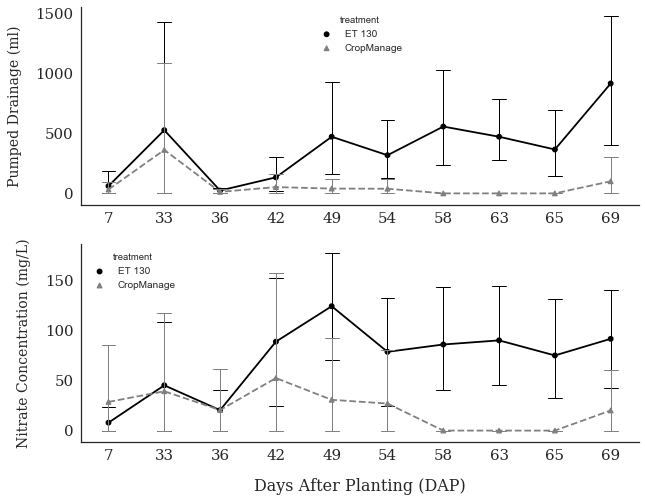

In [7]:
def explore_raw_lysimeter_data(tidy_data): 
    fig, ax=plt.subplots(2,1,figsize=(10,8)) # initiate figure and axis objects
    sns.set(style="ticks", rc={"lines.linewidth": 1})
    # plot drainage
    ax = sns.pointplot(x="DAP", y="drainage_ml", hue="treatment", data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5, ax=ax[0]) 
    ax.set_xlabel(xlabel='', fontsize=20,labelpad=15); 
    ax.set_ylabel('Pumped Drainage (ml)', fontsize=14, labelpad=14); # ax.set_ylim(-20,300)
    ax.tick_params(labelsize=15); 
    # plot nitrate concentration
    ax1 = sns.pointplot(x="DAP", y="N_mg_per_L", hue="treatment", data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5)
    ax1.set_xlabel(xlabel='Days After Planting (DAP)', fontsize=16,labelpad=15);
    ax1.set_ylabel('Nitrate Concentration (mg/L)', fontsize=14, labelpad=14); # ax1.set_ylim(-20,300) 
    ax1.tick_params(labelsize=15); 
    sns.despine() # remove upper and righhand spines
    return fig, ax

# use function to explore raw lysimeter data (unscaled)
explore_raw_lysimeter_data(lysimeter)

In [8]:
# Explore nitrate concentration (mg/L) and the variability between treatments and replicates
#sns.factorplot(x="DAP", y="N_mg_per_L", hue="replicate",
#    col="treatment", data=lysimeter, kind="swarm")

In [9]:
# Explore drainage volumes (ml) and the variability between treatments and replicates
#sns.factorplot(x="DAP", y="drainage_ml", hue="replicate",
#    col="treatment", data=lysimeter, kind="swarm")

# Nitrate Leachate and Deep Drainage Analysis

### ONCE IM HAPPY WITH THE WORKFLOW GO AHEAD AND DIAL THINGS IN AND NUMBER EACH SECTION. maybe put this at the top and add in a couple of other items from the first few things


**The general workflow for the leachate analysis is as follows:**

1. Setup needed Conversion factors.
2. Subset necessary columns for analysis.
3. Determine and create necessary area of influence (AOI) and scaling factor.
4. Use pumped volumes and nitrate concentrations to calculate each component necessary for the analyis.
    - Calculate drainage in inches (from volume). 
    - Convert milliliters (same as cm^3 b/c 1 ml = 1 cm^3) to liters.
    - Calculate milligrams of N (N_mg) by multiplying drainage (L) times concentration (mg/L).
    - Calculate pounds of N (N_lbs) by multiplying concentration (N_mg) times the milligrams to pounds conversion factor.
    - Calculate pounds of N per square centimeters.
    - Calculate pounds of N per acre.

**Note:** Each of these calculations and/or conversions is added as a new column to the leachate data frame (calculations are happening to each instance (record) in the dataframe). The output dataframe (table) then has everything to easily summarize drainage or leachate for the study (e.g., by treatment and by replicate)

In [10]:
# Conversions needed for analysis
# conversion factor for milligrams to pounds (lbs in a mg)
mg_to_lbs = 0.0000022046   #   lb = mg * 0.0000022046

# conversion factor for total square cinemiters in an Acre
cm2_in_acre = 40468564.224

# Conversion factor for going from inches to centimeters
inch_to_cm = 2.54 # conversion factor: centimeters per inch

# Conversion factor for going from centimeters to inches
cm_to_inches = 0.393701 # conversion factor: inches per centimeter

In [11]:
# Subset only the columns needed for leachate analysis and save in variable called 'drainage'
leachate = lysimeter.loc[:, ['event', 'date', 'DAP', 'treatment', 'replicate', 'unique_id', 'drainage_ml', 'N_mg_per_L'] ]

# rename drainage_ml to drainage_cm3 so that the conversion calculation later makes more sense
leachate.rename(columns={'drainage_ml': 'drainage_cm3'}, inplace=True)  # 1 ml = 1 cm^3

leachate.sample(5) # view 5 randomly sampled records in the leachate data

,event,date,DAP,treatment,replicate,unique_id,drainage_cm3,N_mg_per_L
66,9,2017-06-16,65,ET 130,Rep C,D6YL,210,164.714286
54,7,2017-06-09,58,CropManage,Rep C,D6NL,0,0.000000
69,9,2017-06-16,65,CropManage,Rep B,D3NL,0,0.000000
75,10,2017-06-20,69,ET 130,Rep D,D7YL,507,158.201183
56,8,2017-06-14,63,ET 130,Rep A,D2NL,280,74.507143


### Create Scaling Factor that assumes no leaching in furrows (and double check scalar and area of influence
- **Note:** These are in centimeters because they will be used to do calculations on drainage in the leachate data frame

In [12]:
# Function to create scaling factor that assumes no leaching in furrows
def create_scaling_factor(width_of_bed=1, width_of_bed_plus_furrows=1):
    '''The output of this function will be in centimeters'''
    '''This is important for later conversions'''
    # convert width of just the bed from inches to centimeters
    width_of_bed_cm = width_of_bed * inch_to_cm # centimeters
    # convert width of bed (with furrows) from inches to centimeters
    width_of_bed_plus_furrows_cm = width_of_bed_plus_furrows * inch_to_cm # centimeters
    # calculate scaling factor that assumes there was no drainage in furrows
    scaling_factor_cm = width_of_bed_cm / width_of_bed_plus_furrows_cm    
    return scaling_factor_cm

furrow_scalar = create_scaling_factor(width_of_bed, width_of_bed_plus_furrows)

# Check to be sure aoi_cm2 and furrow_scalar are what you expect
print("The Area of Influence being used is: ", aoi_cm2, " cm")
print("The Scaling factor used that assumes the furrows had no drainage is: ", furrow_scalar)

The Area of Influence being used is:  506.7  cm
The Scaling factor used that assumes the furrows had no drainage is:  0.7500000000000001


---

In [13]:
# Calculate drainage in inches (in) for each record and add resulting column to dataframe
leachate.loc[:,'drainage_in'] = (leachate.loc[:, 'drainage_cm3'] / aoi_cm2) * furrow_scalar * cm_to_inches

# Calculate drainage in liters (L) for each record and add resulting column to dataframe
leachate.loc[:,'drainage_L'] = leachate.loc[:,'drainage_cm3'] / 1000

# Calculate nitrate in miligrams (mg) for each record and add resulting column to dataframe
leachate.loc[:,'N_mg'] = leachate.loc[:,'N_mg_per_L'] * leachate.loc[:,'drainage_L'] 

# Calculate nitrate in pounds (lb) for each record and add resulting column to dataframe
leachate.loc[:,'N_lbs'] = leachate.loc[:,'N_mg'] * mg_to_lbs

# Calculate lbs of N per sampling area (cm^2) for each record and add resulting column to dataframe
leachate.loc[:,'N_lbs_per_cm2'] = (leachate.loc[:,'N_lbs'] / aoi_cm2 * furrow_scalar)

# Convert lbs of N per cm^2 to lbs of N per Acre for each record and add resulting column to dataframe
leachate.loc[:,'N_lbs_per_acre'] = leachate.loc[:,'N_lbs_per_cm2'] * cm2_in_acre
    
leachate.sample(5).round(2)

,event,date,DAP,treatment,replicate,unique_id,drainage_cm3,N_mg_per_L,drainage_in,drainage_L,N_mg,N_lbs,N_lbs_per_cm2,N_lbs_per_acre
20,3,2017-05-18,36,CropManage,Rep A,D2YL,0,0.00,0.00,0.00,0.00,0.0,0.0,0.00
38,5,2017-05-31,49,CropManage,Rep C,D6NL,0,0.00,0.00,0.00,0.00,0.0,0.0,0.00
58,8,2017-06-14,63,ET 130,Rep C,D6YL,280,168.00,0.16,0.28,47.04,0.0,0.0,6.21
25,4,2017-05-24,42,ET 130,Rep B,D4YL,360,139.00,0.21,0.36,50.04,0.0,0.0,6.61
72,10,2017-06-20,69,ET 130,Rep A,D2NL,370,122.61,0.22,0.37,45.36,0.0,0.0,5.99


# Exploration of Scaled Lysimeter Data (treatment averages)
Taking a quick look at the unscaled volumes pumped on site and the nitrate concentration from the laboratory analysis.

(<matplotlib.figure.Figure at 0x27538a4feb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27539155160>)

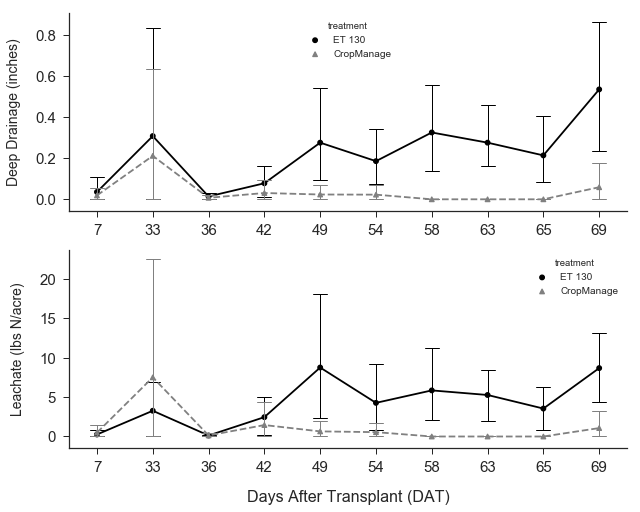

In [14]:
def explore_scaled_lysimeter_data(tidy_data, treatment_one, treatment_two): 
    fig, ax=plt.subplots(2,1,figsize=(10,8)) # initiate figure and axis objects
    sns.set(style="ticks", rc={"lines.linewidth": 1})
    # plot drainage
    ax = sns.pointplot(x="DAP", y="drainage_in", hue="treatment", hue_order=[treatment_one, treatment_two],
                       data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5, ax=ax[0]) 
    ax.set_xlabel(xlabel='', fontsize=20,labelpad=15);
    ax.set_ylabel('Deep Drainage (inches)', fontsize=14, labelpad=14); # ax.set_ylim(-20,300)
    ax.tick_params(labelsize=15); 
    # plot nitrate concentration
    ax1 = sns.pointplot(x="DAP", y="N_lbs_per_acre", hue="treatment", hue_order=[treatment_one, treatment_two],
                        data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5)
    ax1.set_xlabel(xlabel='Days After Transplant (DAT)', fontsize=16,labelpad=15);
    ax1.set_ylabel('Leachate (lbs N/acre)', fontsize=14, labelpad=14); # ax1.set_ylim(-20,300) 
    ax1.tick_params(labelsize=15); 
    sns.despine() # remove upper and righhand spines
    return fig, ax

# use function to explore scaled lysimeter data 
explore_scaled_lysimeter_data(leachate, treatment_one, treatment_two)

# export table 
# plt.savefig(path_figures + r'\scaled-lysimeter-data') # save figure

(<matplotlib.figure.Figure at 0x27538a0ecc0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x27538a4f630>)

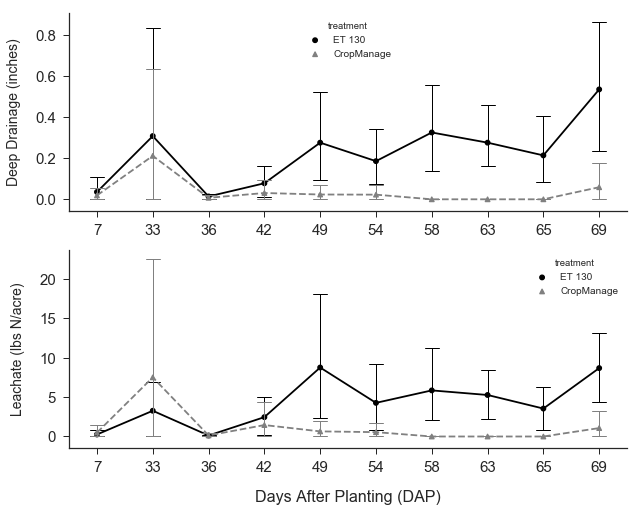

In [15]:
def explore_scaled_lysimeter_data(tidy_data): 
    fig, ax=plt.subplots(2,1,figsize=(10,8)) # initiate figure and axis objects
    sns.set(style="ticks", rc={"lines.linewidth": 1})
    # plot drainage
    ax = sns.pointplot(x="DAP", y="drainage_in", hue="treatment", data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5, ax=ax[0]) 
    ax.set_xlabel(xlabel='', fontsize=20,labelpad=15); 
    ax.set_ylabel('Deep Drainage (inches)', fontsize=14, labelpad=14); # ax.set_ylim(-20,300)
    ax.tick_params(labelsize=15); 
    # plot nitrate concentration
    ax1 = sns.pointplot(x="DAP", y="N_lbs_per_acre", hue="treatment", data=tidy_data, palette=['black','grey'],
                       errwidth=1, markers=["o", "^"], capsize=0.25, linestyles=["-", "--"], linewidth=5)
    ax1.set_xlabel(xlabel='Days After Planting (DAP)', fontsize=16,labelpad=15);
    ax1.set_ylabel('Leachate (lbs N/acre)', fontsize=14, labelpad=14); # ax1.set_ylim(-20,300) 
    ax1.tick_params(labelsize=15); 
    sns.despine() # remove upper and righhand spines
    return fig, ax

# use function to explore scaled lysimeter data (unscaled)
explore_scaled_lysimeter_data(leachate)

---

# Aggregate drainage and leachate data for comparisons

### Group leachate data by treatment and replicate to get a cummulative total for each unique lysimter (replicate)
**Note:** This step is summing all values that were collected for each individual replicate (each lysimeter)


In [16]:
# Set correct data-types for leachate dataframe
leachate.treatment = leachate.treatment.astype('category')
leachate.replicate = leachate.replicate.astype('category')
#leachate.event = leachate.event.astype('category')
#leachate.DAP = leachate.DAP.astype('category')

In [17]:
cummulative_leachate = leachate.groupby(['treatment', 'replicate']).sum().copy()
cummulative_leachate = cummulative_leachate.reset_index()
cummulative_leachate

,treatment,replicate,event,DAP,drainage_cm3,N_mg_per_L,drainage_in,drainage_L,N_mg,N_lbs,N_lbs_per_cm2,N_lbs_per_acre
0,CropManage,Rep A,55,476,403,80.400000,0.234845,0.403,32.40120,0.000071,1.057307e-07,4.278771
1,CropManage,Rep B,55,476,2155,793.543095,1.255811,2.155,326.85375,0.000721,1.066580e-06,43.162981
2,CropManage,Rep C,55,476,0,0.000000,0.000000,0.000,0.00000,0.000000,0.000000e+00,0.000000
3,CropManage,Rep D,55,476,0,0.000000,0.000000,0.000,0.00000,0.000000,0.000000e+00,0.000000
4,ET 130,Rep A,55,476,2038,398.185079,1.187630,2.038,141.77360,0.000313,4.626319e-07,18.722047
5,ET 130,Rep B,55,476,6985,723.147601,4.070458,6.985,670.62300,0.001478,2.188359e-06,88.559754
6,ET 130,Rep C,55,476,2545,1210.697264,1.483080,2.545,274.94615,0.000606,8.971970e-07,36.308274
7,ET 130,Rep D,55,476,3832,497.500043,2.233070,3.832,199.77810,0.000440,6.519106e-07,26.381886


### Use cummulative totals for each replicate (cummulative_leachate) to take mean cummulative per treatment
**Note:** This step is uses the summed totals for each lysimter and groups them together to calculate treatment averages.

In [18]:
# Groupby treatment and take the mean
average_leachate = cummulative_leachate.groupby(['treatment']).mean()

# View dataframe with summaries for each treatment
average_leachate

,event,DAP,drainage_cm3,N_mg_per_L,drainage_in,drainage_L,N_mg,N_lbs,N_lbs_per_cm2,N_lbs_per_acre
treatment,,,,,,,,,,
CropManage,55.0,476.0,639.5,218.485774,0.372664,0.6395,89.813738,0.000198,2.930778e-07,11.860438
ET 130,55.0,476.0,3850.0,707.382497,2.243560,3.8500,321.780213,0.000709,1.050025e-06,42.492990
